### Imports 
- First I change some colors of matplotlib to be legible in a dark visual studio code editor.
- Then I import numpy, pandas and sklearn.  

In [1]:
import matplotlib as mpl

font = {'family' : 'Georgia',
        'weight' : 'bold',
        'size'   : 12}

COLOR = 'gray'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

mpl.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# Classifiers
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.naive_bayes import GaussianNB


### Importing the Dataset
- The dataset contains sonar signals used to distinguish between metal cylinders (mines) and rocks. 
- There are 111 patterns from metal cylinders and 97 from rocks, collected under various conditions and angles. 
- Each pattern includes 60 numbers representing the energy in specific frequency bands, with higher frequencies occurring later. The labels are "R" for rocks and "M" for mines. 

In [2]:

data = pd.read_csv('sonar.all-data-uci.csv')    # Load the dataset
data.head(5)                                    # Show the first 5 rows 


,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### Splitting the data into training and testing sets

In [3]:
# Assign feature columns and target column
X = data.iloc[:, :-1] # Sonar Frequencies 
y = data.iloc[:, -1]  # Rock or Mine Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

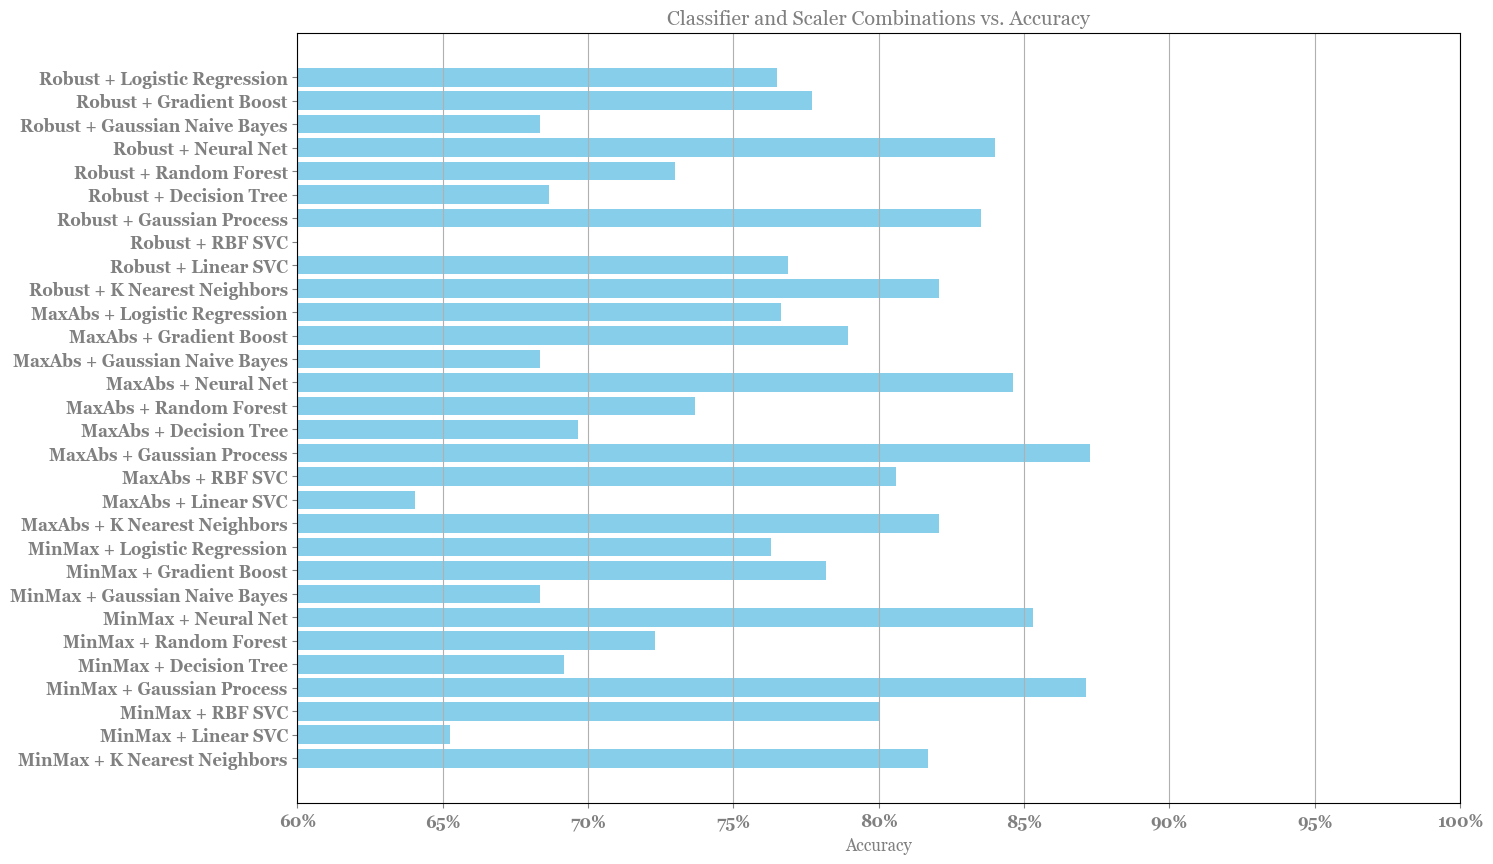

In [4]:
def cross_validation(classifiers, classifier_names, scalers, scaler_names, X, y):
    results = {}
    for scaler, scaler_name in zip(scalers, scaler_names):
        X_scaled = scaler.fit_transform(X)
        train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.33)

        for clf, clf_name in zip(classifiers, classifier_names):
            clf.fit(train_x, train_y)
            y_pred = clf.predict(test_x)
            score = accuracy_score(test_y, y_pred)
            # print(f"Scaler: {scaler_name}, Classifier: {clf_name}, Accuracy: {score:.2f}")

            cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
            cv_scores = cross_val_score(clf, X_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)
            results[(scaler_name, clf_name)] = cv_scores

    return results

# Define scalers and classifiers
scaler_names = ['MinMax', 'MaxAbs', 'Robust']
scalers = [MinMaxScaler(), MaxAbsScaler(), RobustScaler()]

classifier_names = [
    "K Nearest Neighbors", 
    "Linear SVC", 
    "RBF SVC", 
    "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net",
    "Gaussian Naive Bayes", 
    "Gradient Boost", 
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3), 
    SVC(kernel="linear", C=0.025), 
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)), 
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000), 
    GaussianNB(), 
    GradientBoostingClassifier(), 
    LogisticRegression()
]


# Perform cross-validation
results = cross_validation(classifiers, classifier_names, scalers, scaler_names, X_train, y_train)

# Convert results to a DataFrame
data = []
for (scaler_name, clf_name), scores in results.items():
    mean_accuracy = np.mean(scores)
    data.append((scaler_name, clf_name, mean_accuracy))

df = pd.DataFrame(data, columns=['Scaler', 'Classifier', 'Accuracy'])
df['Combination'] = df['Scaler'] + ' + ' + df['Classifier']

# Filter out combinations with accuracy below 50% since they are worse than taking a random guess 
df_filtered = df[df['Accuracy'] >= 0.50]

# Plot the results
plt.figure(figsize=(15, 10))
plt.barh(df_filtered['Combination'], df_filtered['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Classifier and Scaler Combinations vs. Accuracy')
plt.xlim(0.60, 1.0)  # Set x-axis to start at 60%
plt.grid(axis='x')
plt.xticks(ticks=np.arange(0.60, 1.01, 0.05), labels=[f'{int(x * 100)}%' for x in np.arange(0.60, 1.01, 0.05)])
plt.show()

It's clear from the chart that Gaussian Process is the strongest classifier and for scalers MaxAbs slightly outperforms MinMax. So we will continue with MaxAbs and Gaussian Process. 

In [7]:


# Standardize the feature values using Robust Scaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the expanded parameter grid
param_grid = {
    'kernel': [
    1.0 * RBF(length_scale) for length_scale in [0.1, 1.0, 10.0]
    ] + [
    C(1.0, (1e-6, 1e2)) * RBF(length_scale, (1e-6, 1e6)) for length_scale in [0.01, 0.1, 1.0]
    ],
    'n_restarts_optimizer': [0, 1, 2],
    'max_iter_predict': [5, 10, 15, 100],
    'multi_class': ['one_vs_rest', 'one_vs_one'],
    'optimizer': ['fmin_l_bfgs_b', None],
    'n_jobs': [-1]  # Use all available cores
}

# Initialize the classifier
gpc = GaussianProcessClassifier()

# Set up the grid search
grid_search = GridSearchCV(estimator=gpc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the classifier with the best parameters
best_gpc = grid_search.best_estimator_
best_gpc.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
y_pred_best_gpc = best_gpc.predict(X_test_scaled)
accuracy_best_gpc = accuracy_score(y_test, y_pred_best_gpc)

# Generate the classification report
report_dict = classification_report(y_test, y_pred_best_gpc, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

print("Best Gaussian Process Classifier")
print(f"Accuracy: {accuracy_best_gpc:.2f}")

report_df

Best parameters found:  {'kernel': 1**2 * RBF(length_scale=0.1), 'max_iter_predict': 10, 'multi_class': 'one_vs_one', 'n_jobs': -1, 'n_restarts_optimizer': 2, 'optimizer': 'fmin_l_bfgs_b'}
Best Gaussian Process Classifier
Accuracy: 0.90


,precision,recall,f1-score,support
M,0.909091,0.909091,0.909091,22.000000
R,0.900000,0.900000,0.900000,20.000000
accuracy,0.904762,0.904762,0.904762,0.904762
macro avg,0.904545,0.904545,0.904545,42.000000
weighted avg,0.904762,0.904762,0.904762,42.000000


Label 0 corresponds to M
Label 1 corresponds to R


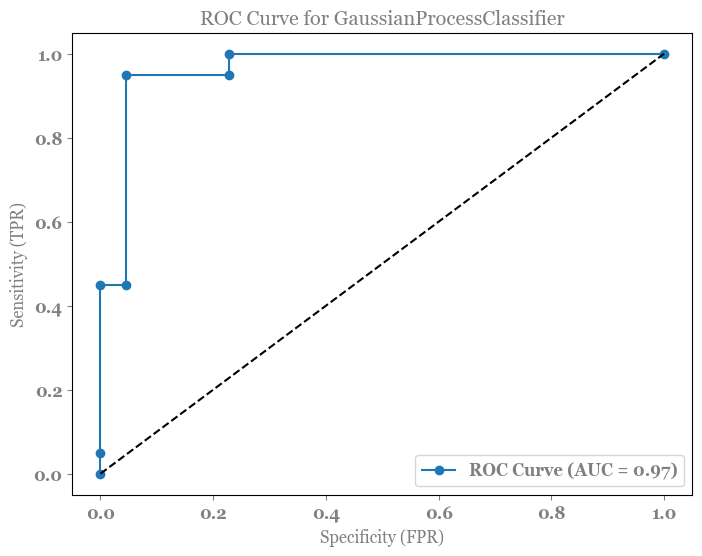

              precision    recall  f1-score    support
0              0.750000  0.954545  0.840000  22.000000
1              0.928571  0.650000  0.764706  20.000000
accuracy       0.809524  0.809524  0.809524   0.809524
macro avg      0.839286  0.802273  0.802353  42.000000
weighted avg   0.835034  0.809524  0.804146  42.000000


In [6]:
def classifierPerformanceTest(X_train, X_test, y_train, y_test, scaler, classifier):

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    # Encode the labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Print label mapping
    for i, label in enumerate(le.classes_):
        print(f"Label {i} corresponds to {label}")

    # Train the classifier with the training data
    classifier.fit(X_train_scaled, y_train_encoded)

    # Evaluate the best model on the test set
    y_pred_classifier = classifier.predict(X_test_scaled)
    accuracy_best_gpc = accuracy_score(y_test_encoded, y_pred_classifier)

    # Generate the classification report
    report_dict = classification_report(y_test_encoded, y_pred_classifier, output_dict=True)

    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(report_dict).transpose()

    y_prob_classifier = classifier.predict_proba(X_test_scaled)[:, 1]

    plot_roc_curve(y_test_encoded, y_prob_classifier, classifier.__class__.__name__)

    print(report_df)


def plot_roc_curve(y_test_encoded, y_prob, classifier_name):
    # Calculate the AUC
    auc = roc_auc_score(y_test_encoded, y_prob)
    
    # Get the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o', linestyle='-', label=f'ROC Curve (AUC = {auc:.2f})')  # Using markers to show discrete points
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for no-skill classifier
    plt.xlabel('Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.show()



# Define the kernel with appropriate bounds
base_kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))

# Set up the best parameters for the classifier
best_params = {
    'kernel': base_kernel,
    'max_iter_predict': 10,
    'multi_class': 'one_vs_rest',
    'n_jobs': -1,
    'n_restarts_optimizer': 0,
    'optimizer': 'fmin_l_bfgs_b'
}

# Initialize the Gaussian Process Classifier with the best parameters
best_gpc = GaussianProcessClassifier(**best_params)

classifierPerformanceTest(X_train, X_test, y_train, y_test, MaxAbsScaler(), best_gpc)



### Interpretation of Metrics
- The model performs very well, with high precision (77.42%) and perfect recall (100%). The high recall indicates that the model correctly identifies all true instances of mines.
- The model has perfect precision (100%) but lower recall (61.11%), indicating that while all predicted rock instances are correct, the model misses a significant portion of actual rock instances.
- Overall Performance: An overall accuracy of ~83.33% is quite good, and the high AUC of 96% further supports the effectiveness of the model in distinguishing between classes. The macro and weighted averages provide additional insights into the model’s performance across both classes, showing a balanced performance.
